In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from math import *
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML
from matplotlib import rc
rc('animation', html='html5')

In [2]:
class Visualize:
    def __init__(self, path, obstacle, limit = 10, obstacle_l = 1):
        fig = plt.figure()
        fig.set_dpi(100)
        fig.set_size_inches(7, 6.5)

        ax = plt.axes(xlim=(0, limit), ylim=(0, limit))
        self.patch = []
        self.addCircle(5,5,'y')
        for p in self.patch:
            ax.add_patch(p)
        self.rectangle = []
        for o in obstacle:
            self.rectangle.append(plt.Rectangle((o[0]-obstacle_l/2, o[1]-obstacle_l/2), obstacle_l, obstacle_l, fc='r'))
            ax.add_patch(self.rectangle[-1])
        self.fig = fig
        self.path = path
        return
    def addCircle(self, x, y, c):
        self.patch.append(plt.Circle((x, y), 0.5, fc=c))
        self.patch[-1].center = (x, y)
    def drawframe(self,n):
        output = []
        for p in range(len(self.patch)):
            x, y = self.patch[p].center
            x = self.path[p][n][0]
            y = self.path[p][n][1]
            self.patch[p].center = (x, y)
            output.append(self.patch[p])
        for obstacle in self.rectangle:
            output.append(obstacle)
        return tuple(output)
    def show(self):
        anim = animation.FuncAnimation(self.fig, self.drawframe, frames=np.shape(self.path)[1]-1, interval=100, blit=True)
        return anim

In [9]:
class VisualizeMulti:
    def __init__(self, path, obstacle, ci = [[5,5,'y']], limit = 10, obstacle_l = 1):
        fig = plt.figure()
        fig.set_dpi(100)
        fig.set_size_inches(7, 6.5)

        ax = plt.axes(xlim=(0, limit), ylim=(0, limit))
        self.patch = []
        for c in ci:
            self.addCircle(c[0],c[1],c[2])
        for p in self.patch:
            ax.add_patch(p)
        self.rectangle = []
        for o in obstacle:
            self.rectangle.append(plt.Rectangle((o[0]-obstacle_l/2, o[1]-obstacle_l/2), obstacle_l, obstacle_l, fc='r'))
            ax.add_patch(self.rectangle[-1])
        self.fig = fig
        self.path = path
        return
    def addCircle(self, x, y, c):
        self.patch.append(plt.Circle((x, y), 0.5, fc=c))
        self.patch[-1].center = (x, y)
    def drawframe(self,n):
        output = []
        for p in range(len(self.patch)):
            if n > len(self.path[p]) -1:
                x, y = self.patch[p].center
            else:
                x = self.path[p][n][0]
                y = self.path[p][n][1]
            self.patch[p].center = (x, y)
            output.append(self.patch[p])
        for obstacle in self.rectangle:
            output.append(obstacle)
        return tuple(output)
    def show(self, frame):
        anim = animation.FuncAnimation(self.fig, self.drawframe, frames=frame, interval=100, blit=True)
        return anim

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import random
from math import *
class environment():
    def __init__(self, obstacle = [[5, 5]], dt = 1,limit = 10, obstacle_l = 1, agentrad = 0.5):
        self.dt = dt
        self.obstacle = obstacle
        self.mindistanceobstacle = obstacle_l/2 + agentrad
        self.mindistanceagent = agentrad*2
        self.discrite_state_limit = limit
        return
    def state_step(self, state, action):
        state_p = [0,0]
        state_p[0] = min(self.discrite_state_limit-1,max(0,state[0] + action[0] * self.dt))
        state_p[1] = min(self.discrite_state_limit-1,max(0,state[1] + action[1] * self.dt))
        return state_p
    def dist(self, a, b):
        d = np.array(a)-np.array(b)
        d = sqrt(np.sum(d*d))
        return d
    def get_reward(self, state, goal, state_others = [], z = 0.1):
        r_shortest_path = 0
        d = self.dist(state, goal)
        r_shortest_path = -1*d
        r_collision = 0
        for o in self.obstacle:
            d = np.array(state)-np.array(o)
            d = d * d
            if d[0] < self.mindistanceobstacle**2 or d[1] < self.mindistanceobstacle**2:
                r_collision -= (self.mindistanceobstacle + z -sqrt(np.sum(d)))
        r_collision_agents = 0
        for o in state_others:
            d = np.array(state)-np.array(o)
            d = d * d
            if d[0] < self.mindistanceobstacle**2 or d[1] < self.mindistanceobstacle**2:
                r_collision_agents -= (self.mindistanceagent + z-sqrt(np.sum(d)))
        return r_shortest_path + r_collision + r_collision_agents 
    def terminate(self,state, goal, z = 1):
        if self.dist(state, goal) < z:
            return 1
        return 0
    def step(self, state, action, goal, state_others = []):
        state_p = self.state_step(state, action)
        reward = self.get_reward(state, goal, state_others )
        done = self.terminate(state, goal)
        return state_p, reward, done    

### One agent

In [4]:
class Agent_SARSA():
    def __init__(self, alpha, epsilon, goal = [9, 9], obstacle = [[5, 5]], dt = 1, discrite_action_count = 4, rad = [1], discrite_state_count = 10, discrite_state_limit = 10):
        action_count = discrite_action_count
        self.env = environment()
        self.alpha = alpha
        state_count = discrite_state_count**2
        self.policy = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa = np.zeros((action_count,state_count))
        self.action_count = action_count
        self.state_count = state_count
        self.R_avg = []
        self.R_sum = []
        if epsilon == 0:
            self.change_epsilon = True
        else:
            self.change_epsilon = False
            self.epsilon = epsilon
        if alpha == 0:
            self.change_alpha = True
        else:
            self.change_alpha = False
            self.alpha = alpha
        self.goal = goal
        if True:
            action = []
            t = np.array(range(discrite_action_count+1))/discrite_action_count*2*pi
            t = t[:-1]
            for  r in rad:
                for theta in t:
                    y = round(r*sin(theta),2)
                    x = round(r*cos(theta),2)
                    action.append([x, y])
            self.action = action
        self.state = 0
        if True:
            self.states = []
            self.statesp = {}
            xlist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            ylist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            for x in xlist:
                for y in ylist:
                    self.states.append([x,y])
                    self.statesp[str(x)+","+str(y)] = len(self.states)-1
        
    
    def main_loop(self, gama = 0.9):
        gama = gama
        for k in range(10000):
            if self.change_epsilon:
                self.epsilon = 100/(100+k)
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            state = np.random.choice([i for i in range(self.state_count)])
            p = random.random()
            R = []
            #[np.argmax([self.Q_sa[i][j] for i in range(self.action_count)]) for j in range(self.state_count)]
            if p< 1-self.epsilon:
                action = np.argmax([self.Q_sa[i][state] for i in range(self.action_count)])
            else:
                action = np.random.choice([i for i in range(self.action_count)])
            flag = False
            length = 0
            while True:
                length = length + 1
                if length > 2000:
                    break
                state_p, reward, done = self.env.step(self.map_state(state), self.map_action(action), self.goal)
                state_p = self.statesp[str(float(round(state_p[0])))+","+str(float(round(state_p[1])))]
                R.append(reward)
                p = random.random()
                if p< 1-self.epsilon:
                    action_p = np.argmax([self.Q_sa[i][state_p] for i in range(self.action_count)])
                else:
                    action_p = np.random.choice([i for i in range(self.action_count)])
                self.Q_sa[action][state] = self.Q_sa[action][state] + self.alpha*(reward+gama*self.Q_sa[action_p][state_p]- self.Q_sa[action][state])
                state = state_p
                action = action_p
                if done:
                    if flag:
                        break
                    else:
                        flag = True
            self.R_avg.append(np.mean(R))
            self.R_sum.append(np.sum(R))
    def map_action(self, index):
        return  self.action[index]
    def map_state(self, index):
        return self.states[index]
    def test(self, state, gama = 0.9):
        gama = gama
        states = []
        for k in range(1):
            if self.change_epsilon:
                self.epsilon = 100/(100+k)
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            states.append(self.map_state(state))
            p = random.random()
            R = []
            #[np.argmax([self.Q_sa[i][j] for i in range(self.action_count)]) for j in range(self.state_count)]
            if p< 1:
                action = np.argmax([self.Q_sa[i][state] for i in range(self.action_count)])
            else:
                action = np.random.choice([i for i in range(self.action_count)])
            flag = False
            length = 0
            while True:
                length = length + 1
                if length > 200:
                    break
                state_p, reward, done = self.env.step(self.map_state(state), self.map_action(action), self.goal)
                state_p = self.statesp[str(float(round(state_p[0])))+","+str(float(round(state_p[1])))]
                R.append(reward)
                p = random.random()
                if p< 1:
                    action_p = np.argmax([self.Q_sa[i][state_p] for i in range(self.action_count)])
                else:
                    action_p = np.random.choice([i for i in range(self.action_count)])
                state = state_p
                states.append(self.map_state(state))
                action = action_p
                if done:
                    if flag:
                        break
                    else:
                        flag = True
        return states

[]

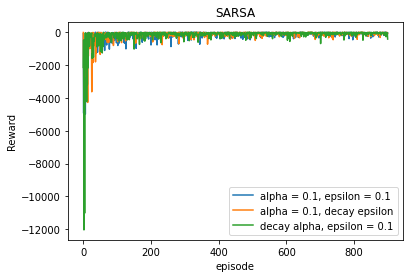

In [5]:
agent_sarsa =  Agent_SARSA(0.1,0.1, obstacle = [[5.5,5.5],[4.5,4.5]])
agent_sarsa.main_loop()
t = {}
t["alpha = 0.1, epsilon = 0.1"] = agent_sarsa.R_sum
agent_sarsa =  Agent_SARSA(0.1,0, obstacle = [[5.5,5.5],[4.5,4.5]])
agent_sarsa.main_loop()
t["alpha = 0.1, decay epsilon"] = agent_sarsa.R_sum
agent_sarsa =  Agent_SARSA(0,0.1, obstacle = [[5.5,5.5],[4.5,4.5]])
agent_sarsa.main_loop()
t["decay alpha, epsilon = 0.1"] = agent_sarsa.R_sum
agent_sarsa =  Agent_SARSA(0,0, obstacle = [[5.5,5.5],[4.5,4.5]])
agent_sarsa.main_loop()
t["decay alpha, epsilon = 0.1"] = agent_sarsa.R_sum
plt.title("SARSA")
for k in t.keys():
    plt.plot(t[k], label = k)
plt.xlabel("episode")
plt.ylabel("Reward")
plt.legend()
plt.plot()

[]

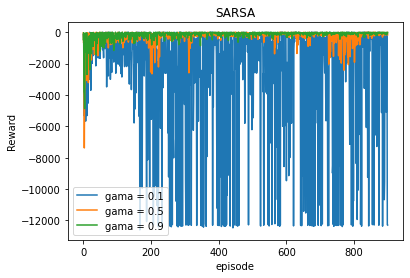

In [26]:
t = {}
agent_sarsa =  Agent_SARSA(0.1,0.1, obstacle = [[5.5,5.5],[4.5,4.5]])
agent_sarsa.main_loop(0.1)
t["gama = 0.1"] = agent_sarsa.R_sum
agent_sarsa =  Agent_SARSA(0.1,0.1, obstacle = [[5.5,5.5],[4.5,4.5]])
agent_sarsa.main_loop(0.5)
t["gama = 0.5"] = agent_sarsa.R_sum
agent_sarsa =  Agent_SARSA(0.1,0.1, obstacle = [[5.5,5.5],[4.5,4.5]])
agent_sarsa.main_loop()
t["gama = 0.9"] = agent_sarsa.R_sum
plt.title("SARSA")
for k in t.keys():
    plt.plot(t[k], label = k)
plt.xlabel("episode")
plt.ylabel("Reward")
plt.legend()
plt.plot()

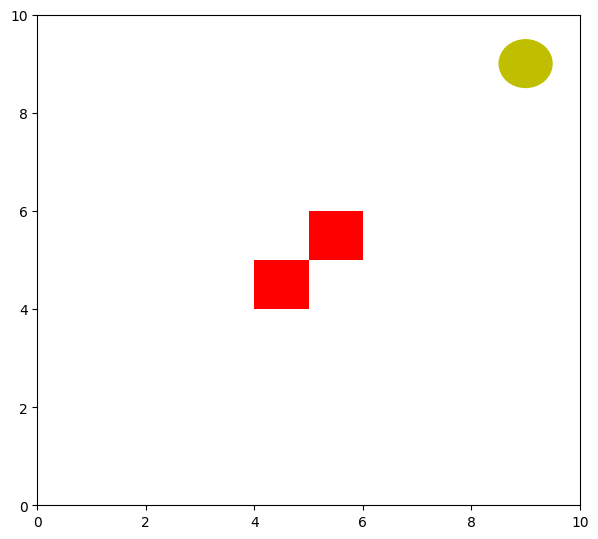

In [ ]:
path = agent_sarsa.test(9)
Visualize([path], [[5.5,5.5],[4.5,4.5]]).show()

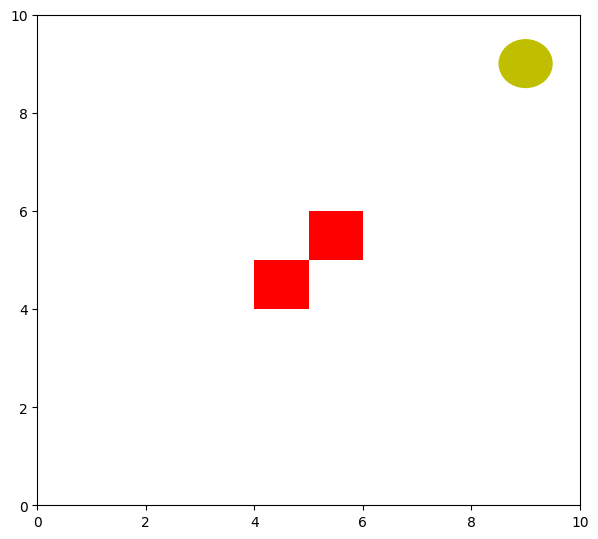

In [ ]:
path = agent_sarsa.test(0)
Visualize([path], [[5.5,5.5],[4.5,4.5]]).show()

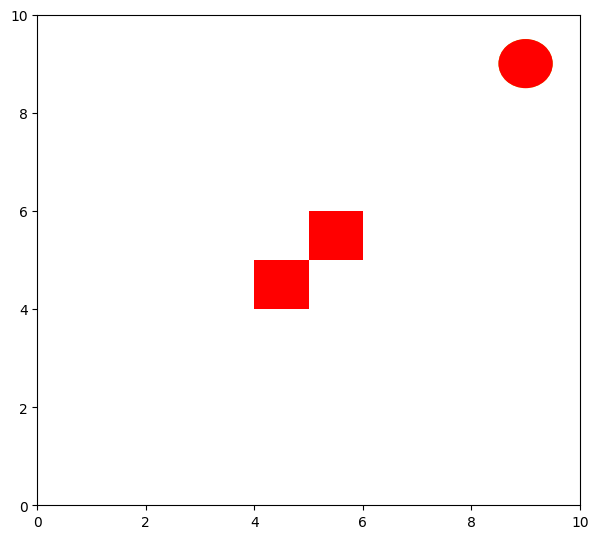

In [12]:
path1 = agent_sarsa.test(60)
path2 = agent_sarsa.test(19)
VisualizeMulti([path1, path2], [[5.5,5.5],[4.5,4.5]], [[5,5,'y'],[5,5,'r']]).show(np.max([len(path1),len(path2)]))

In [16]:
class Agent_QL():
    def __init__(self, alpha, epsilon, goal = [9, 9], obstacle = [[5, 5]], dt = 1, discrite_action_count = 4, rad = [1], discrite_state_count = 10, discrite_state_limit = 10):
        action_count = discrite_action_count
        self.env = environment()
        self.alpha = alpha
        state_count = discrite_state_count**2
        self.policy = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa = np.zeros((action_count,state_count))
        self.action_count = action_count
        self.state_count = state_count
        self.R_avg = []
        self.R_sum = []
        if epsilon == 0:
            self.change_epsilon = True
        else:
            self.change_epsilon = False
            self.epsilon = epsilon
        if alpha == 0:
            self.change_alpha = True
        else:
            self.change_alpha = False
            self.alpha = alpha
        self.goal = goal
        if True:
            action = []
            t = np.array(range(discrite_action_count+1))/discrite_action_count*2*pi
            t = t[:-1]
            for  r in rad:
                for theta in t:
                    y = round(r*sin(theta),2)
                    x = round(r*cos(theta),2)
                    action.append([x, y])
            self.action = action
        self.state = 0
        if True:
            self.states = []
            self.statesp = {}
            xlist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            ylist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            for x in xlist:
                for y in ylist:
                    self.states.append([x,y])
                    self.statesp[str(x)+","+str(y)] = len(self.states)-1
        
    
    def main_loop(self, gama = 0.9):
        gama = gama
        for k in range(10000):
            if self.change_epsilon:
                self.epsilon = 100/(100+k)
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            state = np.random.choice([i for i in range(self.state_count)])
            p = random.random()
            R = []
            if p< 1-self.epsilon:
                action = np.argmax([self.Q_sa[i][state] for i in range(self.action_count)])
            else:
                action = np.random.choice([i for i in range(self.action_count)])
            flag = False
            length = 0
            while True:
                length = length + 1
                if length > 2000:
                    break
                state_p, reward, done = self.env.step(self.map_state(state), self.map_action(action), self.goal)
                state_p = self.statesp[str(float(round(state_p[0])))+","+str(float(round(state_p[1])))]
                R.append(reward)
                p = random.random()
                self.Q_sa[action][state] = self.Q_sa[action][state] + self.alpha*(reward+gama*np.max([self.Q_sa[i][state_p] for i in range(self.action_count)])- self.Q_sa[action][state])
                if p< 1-self.epsilon:
                    action_p = np.argmax([self.Q_sa[i][state_p] for i in range(self.action_count)])
                else:
                    action_p = np.random.choice([i for i in range(self.action_count)])
                state = state_p
                action = action_p
                if done:
                    if flag:
                        break
                    else:
                        flag = True
            self.R_avg.append(np.mean(R))
            self.R_sum.append(np.sum(R))
    def map_action(self, index):
        return  self.action[index]
    def map_state(self, index):
        return self.states[index]
    def test(self, state, gama = 0.9):
        gama = gama
        states = []
        for k in range(1):
            if self.change_epsilon:
                self.epsilon = 100/(100+k)
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            states.append(self.map_state(state))
            p = random.random()
            R = []
            #[np.argmax([self.Q_sa[i][j] for i in range(self.action_count)]) for j in range(self.state_count)]
            if p< 1:
                action = np.argmax([self.Q_sa[i][state] for i in range(self.action_count)])
            else:
                action = np.random.choice([i for i in range(self.action_count)])
            flag = False
            length = 0
            while True:
                length = length + 1
                if length > 200:
                    break
                state_p, reward, done = self.env.step(self.map_state(state), self.map_action(action), self.goal)
                state_p = self.statesp[str(float(round(state_p[0])))+","+str(float(round(state_p[1])))]
                R.append(reward)
                p = random.random()
                if p< 1:
                    action_p = np.argmax([self.Q_sa[i][state_p] for i in range(self.action_count)])
                else:
                    action_p = np.random.choice([i for i in range(self.action_count)])
                state = state_p
                states.append(self.map_state(state))
                action = action_p
                if done:
                    if flag:
                        break
                    else:
                        flag = True
        return states

In [17]:
agent_ql =  Agent_QL(0.1,0.1, obstacle = [[5.5,5.5],[4.5,4.5]])
agent_ql.main_loop()

[]

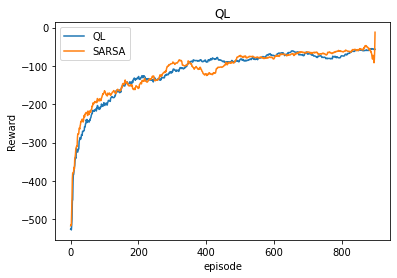

In [21]:
plt.title("QL")
plt.plot([np.mean(agent_ql.R_sum[i:i+100]) for i in range(900)], label = "QL")
plt.plot([np.mean(t["gama = 0.9"][i:i+100]) for i in range(900)], label = "SARSA")
plt.xlabel("episode")
plt.ylabel("Reward")
plt.legend()
plt.plot()

Actor Critic

In [27]:
class AC:
    def __init__(self, beta, alpha, gama, N, goal = [9, 9], obstacle = [[5, 5]], discrite_action_count = 4, rad = [1], discrite_state_count = 10, discrite_state_limit = 10):
        action_count = discrite_action_count
        self.env = environment()
        self.alpha = alpha
        state_count = discrite_state_count**2
        self.policy = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa = np.zeros((action_count,state_count))
        self.action_count = action_count
        self.state_count = state_count
        self.R_avg = []
        self.R_sum = []
        if alpha == 0:
            self.change_alpha = True
        else:
            self.change_alpha = False
            self.alpha = alpha
        if beta == 0:
            self.change_beta = True
        else:
            self.change_beta = False
            self.beta = beta
        self.goal = goal
        if True:
            action = []
            t = np.array(range(discrite_action_count+1))/discrite_action_count*2*pi
            t = t[:-1]
            for  r in rad:
                for theta in t:
                    y = round(r*sin(theta),2)
                    x = round(r*cos(theta),2)
                    action.append([x, y])
            self.action = action
        self.state = 0
        if True:
            self.states = []
            self.statesp = {}
            xlist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            ylist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            for x in xlist:
                for y in ylist:
                    self.states.append([x,y])
                    self.statesp[str(x)+","+str(y)] = len(self.states)-1
        self.N = N
        self.C = np.array([np.linspace(0, 1, N)*10,np.linspace(0, 1, N)*10,np.linspace(0, 1, N)*2-1,np.linspace(0, 1, N)*2-1]).T
        self.B = np.array([[0.1,0,0,0],[0,0.1,0,0],[0,0,0.1,0],[0,0,0,0.1]])
        self.theta = np.ones(N)
        self.w = np.ones(N)
    def phi(self, state, action):
        Phi_vec=[]
        x = []
        for z in self.map_state(state):
            x.append(z)
        for z in self.map_action(action):
            x.append(z)
        for i in range(self.N):
            Phi_i=exp(-1/2*np.dot(np.dot(np.array(x-self.C[i]),np.linalg.pinv(self.B)),np.array(x-self.C[i])))
            Phi_vec.append(np.array(Phi_i))
        Phi_vec = np.array(Phi_vec)+0.001
        phi=Phi_vec/np.sum(Phi_vec)
        return np.array(phi)
    def select_action(self, state):
        p = np.array([np.exp(np.dot(self.phi(state, i),self.theta)) for i in range(self.action_count)])+0.001
        p = np.array(p)/np.sum(p)
        action = np.random.choice([i for i in range(self.action_count)], p = p)
        return action
    def update_Q(self, state, action, state_p, action_p, reward, gama):
        delta = reward + gama*np.dot(self.phi(state_p,action_p),self.w) - np.dot(self.phi(state,action),self.w)
        self.theta = self.theta + self.alpha*self.phi(state, action)*np.dot(self.phi(state,action),self.w)
        self.w = self.w + self.beta*delta*self.phi(state, action)
        return
    def main_loop(self, gama = 0.9):
        gama = gama
        for k in range(1000):
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            if self.change_beta:
                self.beta = 100/(1000+k)
            state = np.random.choice([i for i in range(self.state_count)])     
            R = []
            action = self.select_action(state)
            flag = False
            length = 0
            while True:
                length = length + 1
                if length > 200:
                    break
                state_p, reward, done = self.env.step(self.map_state(state), self.map_action(action), self.goal)
                state_p = self.statesp[str(float(round(state_p[0])))+","+str(float(round(state_p[1])))]
                R.append(reward)
                action_p = self.select_action(state_p)
                self.update_Q(state, action, state_p, action_p, reward, gama)
                state = state_p
                action = action_p
                if done:
                    if flag:
                        break
                    else:
                        flag = True
            self.R_avg.append(np.mean(R))
            self.R_sum.append(np.sum(R))
    def map_action(self, index):
        return  self.action[index]
    def map_state(self, index):
        return self.states[index]

In [30]:
t = {}
agent =  AC(beta = 0, alpha = 0, gama = 0.9, N = 1, obstacle = [[5.5,5.5],[4.5,4.5]])
agent.main_loop()
t["N=1"] = agent.R_sum
agent =  AC(beta = 0, alpha = 0, gama = 0.9, N = 3, obstacle = [[5.5,5.5],[4.5,4.5]])
agent.main_loop()
t["N=3"] = agent.R_sum
agent =  AC(beta = 0, alpha = 0, gama = 0.9, N = 10, obstacle = [[5.5,5.5],[4.5,4.5]])
agent.main_loop()
t["N=10"] = agent.R_sum

[]

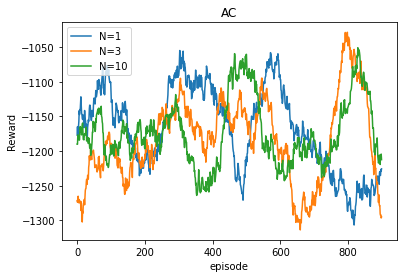

In [32]:
plt.title("AC")
for k in t.keys():
    plt.plot([np.mean(t[k][i:i+100]) for i in range(900)], label = k)
plt.xlabel("episode")
plt.ylabel("Reward")
plt.legend()
plt.plot()

In [33]:
t = {}
agent =  AC(beta = 0.1, alpha = 0.1, gama = 0.9, N = 1, obstacle = [[5.5,5.5],[4.5,4.5]])
agent.main_loop()
t["N=1"] = agent.R_sum
agent =  AC(beta = 0.1, alpha = 0.1, gama = 0.9, N = 3, obstacle = [[5.5,5.5],[4.5,4.5]])
agent.main_loop()
t["N=3"] = agent.R_sum
agent =  AC(beta = 0.1, alpha = 0.1, gama = 0.9, N = 10, obstacle = [[5.5,5.5],[4.5,4.5]])
agent.main_loop()
t["N=10"] = agent.R_sum

[]

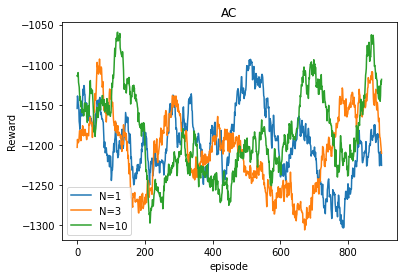

In [34]:
plt.title("AC")
for k in t.keys():
    plt.plot([np.mean(t[k][i:i+100]) for i in range(900)], label = k)
plt.xlabel("episode")
plt.ylabel("Reward")
plt.legend()
plt.plot()

In [ ]:
class AC:
    def __init__(self, beta, alpha, gama, N, goal = [9, 9], obstacle = [[5, 5]], discrite_action_count = 4, rad = [1], discrite_state_count = 10, discrite_state_limit = 10):
        action_count = discrite_action_count
        self.env = environment()
        self.alpha = alpha
        state_count = discrite_state_count**2
        self.policy = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa = np.zeros((action_count,state_count))
        self.action_count = action_count
        self.state_count = state_count
        self.R_avg = []
        self.R_sum = []
        if alpha == 0:
            self.change_alpha = True
        else:
            self.change_alpha = False
            self.alpha = alpha
        if beta == 0:
            self.change_beta = True
        else:
            self.change_beta = False
            self.beta = beta
        self.goal = goal
        if True:
            action = []
            t = np.array(range(discrite_action_count+1))/discrite_action_count*2*pi
            t = t[:-1]
            for  r in rad:
                for theta in t:
                    y = round(r*sin(theta),2)
                    x = round(r*cos(theta),2)
                    action.append([x, y])
            self.action = action
        self.state = 0
        if True:
            self.states = []
            self.statesp = {}
            xlist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            ylist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            for x in xlist:
                for y in ylist:
                    self.states.append([x,y])
                    self.statesp[str(x)+","+str(y)] = len(self.states)-1
        self.N = N
        self.C = np.array([np.linspace(0, 1, N)*10,np.linspace(0, 1, N)*10,np.linspace(0, 1, N)*2-1,np.linspace(0, 1, N)*2-1]).T
        self.B = np.array([[0.1,0,0,0],[0,0.1,0,0],[0,0,0.1,0],[0,0,0,0.1]])
        self.theta = np.ones(N)
        self.w = np.ones(N)
        self.expected = np.ones(state_count)
    def phi(self, state, action):
        Phi_vec=[]
        x = []
        for z in self.map_state(state):
            x.append(z)
        for z in self.map_action(action):
            x.append(z)
        for i in range(self.N):
            Phi_i=exp(-1/2*np.dot(np.dot(np.array(x-self.C[i]),np.linalg.pinv(self.B)),np.array(x-self.C[i])))
            Phi_vec.append(np.array(Phi_i))
        Phi_vec = np.array(Phi_vec)+0.001
        phi=Phi_vec/np.sum(Phi_vec)
        return np.array(phi)
    def select_action(self, state):
        p = np.array([np.exp(np.dot(self.phi(state, i),self.theta)) for i in range(self.action_count)])+0.001
        p = np.array(p)/np.sum(p)
        action = np.random.choice([i for i in range(self.action_count)], p = p)
        return action
    def update_Q(self, state, action, state_p, action_p, reward, gama):
        delta = reward + gama*np.dot(self.phi(state_p,action_p),self.w) - np.dot(self.phi(state,action),self.w)
        self.expected[state] = (1-self.alpha)*self.expected[state]+self.alpha*np.dot(self.phi(state,action),self.w)
        self.theta = self.theta + self.alpha*(self.phi(state, action)-self.expected[state])*np.dot(self.phi(state,action),self.w)
        self.w = self.w + self.beta*delta*self.phi(state, action)
        return
    def main_loop(self, gama = 0.9):
        gama = gama
        for k in range(1000):
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            if self.change_beta:
                self.beta = 100/(1000+k)
            state = np.random.choice([i for i in range(self.state_count)])     
            R = []
            action = self.select_action(state)
            flag = False
            length = 0
            while True:
                length = length + 1
                if length > 200:
                    break
                state_p, reward, done = self.env.step(self.map_state(state), self.map_action(action), self.goal)
                state_p = self.statesp[str(float(round(state_p[0])))+","+str(float(round(state_p[1])))]
                R.append(reward)
                action_p = self.select_action(state_p)
                self.update_Q(state, action, state_p, action_p, reward, gama)
                state = state_p
                action = action_p
                if done:
                    if flag:
                        break
                    else:
                        flag = True
            self.R_avg.append(np.mean(R))
            self.R_sum.append(np.sum(R))
    def map_action(self, index):
        return  self.action[index]
    def map_state(self, index):
        return self.states[index]

In [ ]:
t = {}
agent =  AC(beta = 0, alpha = 0, gama = 0.9, N = 1, obstacle = [[5.5,5.5],[4.5,4.5]])
agent.main_loop()
t["N=1"] = agent.R_sum
agent =  AC(beta = 0, alpha = 0, gama = 0.9, N = 3, obstacle = [[5.5,5.5],[4.5,4.5]])
agent.main_loop()
t["N=3"] = agent.R_sum
agent =  AC(beta = 0, alpha = 0, gama = 0.9, N = 10, obstacle = [[5.5,5.5],[4.5,4.5]])
agent.main_loop()
t["N=10"] = agent.R_sum

[]

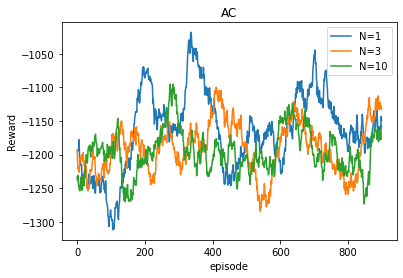

In [ ]:
plt.title("AC")
for k in t.keys():
    plt.plot([np.mean(t[k][i:i+100]) for i in range(900)], label = k)
plt.xlabel("episode")
plt.ylabel("Reward")
plt.legend()
plt.plot()

In [ ]:
t = {}
agent =  AC(beta = 0.1, alpha = 0.1, gama = 0.9, N = 1, obstacle = [[5.5,5.5],[4.5,4.5]])
agent.main_loop()
t["N=1"] = agent.R_sum
agent =  AC(beta = 0.1, alpha = 0.1, gama = 0.9, N = 3, obstacle = [[5.5,5.5],[4.5,4.5]])
agent.main_loop()
t["N=3"] = agent.R_sum
agent =  AC(beta = 0.1, alpha = 0.1, gama = 0.9, N = 10, obstacle = [[5.5,5.5],[4.5,4.5]])
agent.main_loop()
t["N=10"] = agent.R_sum

[]

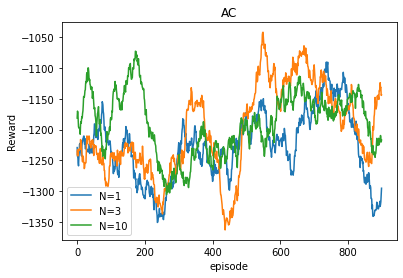

In [ ]:
plt.title("AC")
for k in t.keys():
    plt.plot([np.mean(t[k][i:i+100]) for i in range(900)], label = k)
plt.xlabel("episode")
plt.ylabel("Reward")
plt.legend()
plt.plot()

### Multi agent

In [ ]:
class multiAgentSARSA():
    def __init__(self, alpha, epsilon, goal = [9, 9], obstacle = [[5, 5]], dt = 1, discrite_action_count = 4, rad = [1], discrite_state_count = 10, discrite_state_limit = 10):
        action_count = discrite_action_count
        self.env = environment()
        self.alpha = alpha
        state_count = discrite_state_count**2
        self.Vs_A = np.zeros(state_count)
        self.Vs_B = np.zeros(state_count)
        self.policy_A = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa_A = np.zeros((action_count, action_count,state_count))
        self.policy_B = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa_B = np.zeros((action_count, action_count,state_count))
        self.action_count = action_count
        self.state_count = state_count
        self.R_avg1 = []
        self.R_sum1 = []
        self.R_avg2 = []
        self.R_sum2 = []
        if epsilon == 0:
            self.change_epsilon = True
        else:
            self.change_epsilon = False
            self.epsilon = epsilon
        if alpha == 0:
            self.change_alpha = True
        else:
            self.change_alpha = False
            self.alpha = alpha
        self.goal = goal
        if True:
            action = []
            t = np.array(range(discrite_action_count+1))/discrite_action_count*2*pi
            t = t[:-1]
            for  r in rad:
                for theta in t:
                    y = round(r*sin(theta),2)
                    x = round(r*cos(theta),2)
                    action.append([x, y])
            self.action = action
        if True:
            self.states = []
            self.statesp = {}
            xlist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            ylist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            for x in xlist:
                for y in ylist:
                    self.states.append([x,y])
                    self.statesp[str(x)+","+str(y)] = len(self.states)-1
        
    def select_action(self, Q_sa, state, action2 = 0):
        p = random.random()
        if p< 1-self.epsilon:
            action = np.argmax([Q_sa[i][action2][state] for i in range(self.action_count)])
            #action = np.argmax(np.max([[Q_sa[i][j][state] for j in range(self.action_count)] for i in range(self.action_count)]))
        else:
            action = np.random.choice([i for i in range(self.action_count)]) 
        return action   
    def update(self, state, action1, action2, reward, gama, state_p, v, actionp1, actionp2, Q_sa):
        Q_sa[action1][action2][state] = (1-self.alpha)*Q_sa[action1][action2][state] + self.alpha*(reward+gama*v[state_p])
        v[state_p] = Q_sa[actionp1][actionp2][state_p]
        return v
    def main_loop(self, gama = 0.9):
        gama = gama
        for k in range(10000):
            if self.change_epsilon:
                self.epsilon = 100/(100+k)
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            state1 = np.random.choice([i for i in range(self.state_count)])
            state2 = np.random.choice([i for i in range(self.state_count)])
            R1 = []
            R2 = []
            #[np.argmax([self.Q_sa[i][j] for i in range(self.action_count)]) for j in range(self.state_count)]
            action1 = self.select_action( self.Q_sa_A, state1)
            action2 = self.select_action( self.Q_sa_B, state2, action1)
            flag = False
            length = 0
            while True:
                length = length + 1
                if length > 2000:
                    break
                state_p1, reward1, done1 = self.env.step(self.map_state(state1), self.map_action(action1), self.goal,[self.map_state(state2)])
                state_p1 = self.statesp[str(float(round(state_p1[0])))+","+str(float(round(state_p1[1])))]
                R1.append(reward1)
                state_p2, reward2, done2 = self.env.step(self.map_state(state2), self.map_action(action2), self.goal,[self.map_state(state_p1)])
                state_p2 = self.statesp[str(float(round(state_p2[0])))+","+str(float(round(state_p2[1])))]
                R2.append(reward2)
                action_p1 = self.select_action( self.Q_sa_A, state_p1, action2)
                action_p2 = self.select_action( self.Q_sa_B, state_p2, action_p1)
                self.Vs_A = self.update(state1, action1, action2, reward1, gama, state_p1, self.Vs_A, action_p1, action_p2, self.Q_sa_A)
                self.Vs_B = self.update(state2, action2, action1, reward2, gama, state_p2, self.Vs_B, action_p2, action_p1, self.Q_sa_B)
                state1 = state_p1
                action1 = action_p1
                state2 = state_p2
                action2 = action_p2
                if done1 or done2:
                    if flag:
                        break
                    else:
                        flag = True
            self.R_avg1.append(np.mean(R1))
            self.R_sum1.append(np.sum(R1))
            self.R_avg2.append(np.mean(R2))
            self.R_sum2.append(np.sum(R2))
    def map_action(self, index):
        return  self.action[index]
    def map_state(self, index):
        return self.states[index]
    def test(self, state1, state2, gama = 0.9):
        gama = gama
        states1 = []
        states2 = []
        for k in range(1):
            R1 = []
            R2 = []
            #[np.argmax([self.Q_sa[i][j] for i in range(self.action_count)]) for j in range(self.state_count)]
            action1 = self.select_action( self.Q_sa_A, state1)
            action2 = self.select_action( self.Q_sa_B, state2, action1)
            flag = False
            length = 0
            while True:
                length = length + 1
                if length > 200:
                    break
                state_p1, reward1, done1 = self.env.step(self.map_state(state1), self.map_action(action1), self.goal)
                states1.append(state_p1)
                state_p1 = self.statesp[str(float(round(state_p1[0])))+","+str(float(round(state_p1[1])))]
                R1.append(reward1)
                state_p2, reward2, done2 = self.env.step(self.map_state(state2), self.map_action(action2), self.goal)
                states2.append(state_p2)
                state_p2 = self.statesp[str(float(round(state_p2[0])))+","+str(float(round(state_p2[1])))]
                R2.append(reward2)
                self.epsilon = 0
                action_p1 = self.select_action( self.Q_sa_A, state_p1, action2)
                action_p2 = self.select_action( self.Q_sa_B, state_p2, action_p1)
                state1 = state_p1
                action1 = action_p1
                state2 = state_p2
                action2 = action_p2
                if done1 or done2:
                    if flag:
                        break
                    else:
                        flag = True
            self.R_avg1.append(np.mean(R1))
            self.R_sum1.append(np.sum(R1))
            self.R_avg2.append(np.mean(R2))
            self.R_sum2.append(np.sum(R2))
        return states1, states2

In [ ]:
agent_sarsa =  multiAgentSARSA(0.1,0.1, obstacle = [[5.5,5.5],[4.5,4.5]])
agent_sarsa.main_loop()

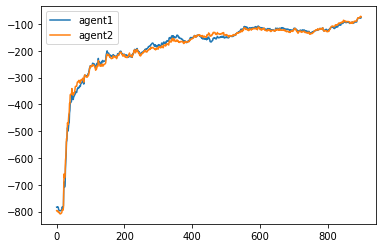

In [ ]:
plt.plot([np.mean(agent_sarsa.R_sum1[i:i+100]) for i in range(900)], label = "agent1")
plt.plot([np.mean(agent_sarsa.R_sum2[i:i+100]) for i in range(900)], label = "agent2")
plt.legend()

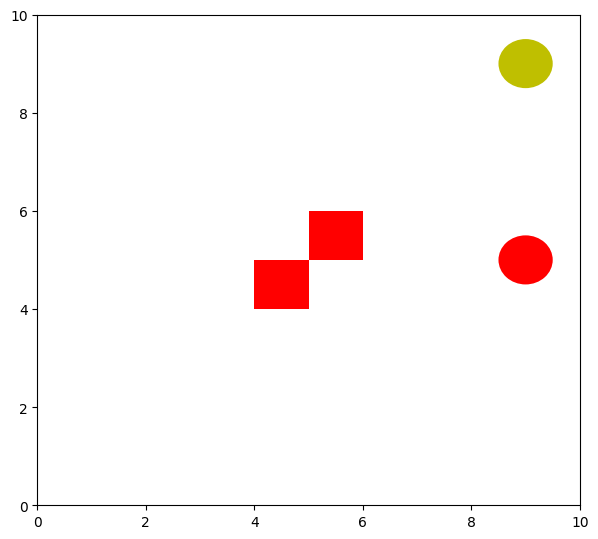

In [ ]:
path1, path2 = agent_sarsa.test(60, 30)
VisualizeMulti([path1, path2], [[5.5,5.5],[4.5,4.5]], [[5,5,'y'],[5,5,'r']]).show(np.max([len(path1),len(path2)]))

In [46]:
class multiAgentMinMax():
    def __init__(self, alpha, epsilon, goal = [9, 9], obstacle = [[5, 5]], dt = 1, discrite_action_count = 4, rad = [1], discrite_state_count = 10, discrite_state_limit = 10):
        action_count = discrite_action_count
        self.env = environment()
        self.alpha = alpha
        state_count = discrite_state_count**2
        self.Vs_A = np.zeros(state_count)
        self.Vs_B = np.zeros(state_count)
        self.policy_A = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa_A = np.zeros((action_count, action_count,state_count))
        self.policy_B = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa_B = np.zeros((action_count, action_count,state_count))
        self.action_count = action_count
        self.state_count = state_count
        self.R_avg1 = []
        self.R_sum1 = []
        self.R_avg2 = []
        self.R_sum2 = []
        if epsilon == 0:
            self.change_epsilon = True
        else:
            self.change_epsilon = False
            self.epsilon = epsilon
        if alpha == 0:
            self.change_alpha = True
        else:
            self.change_alpha = False
            self.alpha = alpha
        self.goal = goal
        if True:
            action = []
            t = np.array(range(discrite_action_count+1))/discrite_action_count*2*pi
            t = t[:-1]
            for  r in rad:
                for theta in t:
                    y = round(r*sin(theta),2)
                    x = round(r*cos(theta),2)
                    action.append([x, y])
            self.action = action
        if True:
            self.states = []
            self.statesp = {}
            xlist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            ylist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            for x in xlist:
                for y in ylist:
                    self.states.append([x,y])
                    self.statesp[str(x)+","+str(y)] = len(self.states)-1
        
    def select_action(self, Q_sa, state, action2 = 0):
        p = random.random()
        if p< 1-self.epsilon:
            action = np.argmax([Q_sa[i][action2][state] for i in range(self.action_count)])
            #action = np.argmax(np.max([[Q_sa[i][j][state] for j in range(self.action_count)] for i in range(self.action_count)]))
        else:
            action = np.random.choice([i for i in range(self.action_count)]) 
        return action   
    def update(self, state, action1, action2, reward, gama, state_p, v, Q_sa):
        Q_sa[action1][action2][state] = (1-self.alpha)*Q_sa[action1][action2][state] + self.alpha*(reward+gama*v[state_p])
        p = np.ones(self.action_count)#*self.epsilon/(self.action_count)
        #best = np.argmax([Q_sa[i][action2][state] for i in range(self.action_count)])
        #p[best] += (1-self.epsilon)    
        v[state_p] = np.max(np.min(Q_sa[:,:,state], axis=0))
        #v[state_p] = np.min([np.sum([Q_sa[i][j][state]*p[j] for i in range(self.action_count)]) for j in range(self.action_count)])
        return v
    def main_loop(self, gama = 0.9):
        gama = gama
        for k in range(10000):
            if self.change_epsilon:
                self.epsilon = 100/(100+k)
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            state1 = np.random.choice([i for i in range(self.state_count)])
            state2 = np.random.choice([i for i in range(self.state_count)])
            R1 = []
            R2 = []
            #[np.argmax([self.Q_sa[i][j] for i in range(self.action_count)]) for j in range(self.state_count)]
            action1 = self.select_action( self.Q_sa_A, state1)
            action2 = self.select_action( self.Q_sa_B, state2, action1)
            flag = False
            length = 0
            while True:
                length = length + 1
                if length > 2000:
                    break
                state_p1, reward1, done1 = self.env.step(self.map_state(state1), self.map_action(action1), self.goal, [self.map_state(state2)])
                state_p1 = self.statesp[str(float(round(state_p1[0])))+","+str(float(round(state_p1[1])))]
                R1.append(reward1)
                state_p2, reward2, done2 = self.env.step(self.map_state(state2), self.map_action(action2), self.goal, self.map_state(state_p1))
                state_p2 = self.statesp[str(float(round(state_p2[0])))+","+str(float(round(state_p2[1])))]
                R2.append(reward2)
                self.Vs_A = self.update(state1, action1, action2, reward1, gama, state_p1, self.Vs_A,  self.Q_sa_A)
                self.Vs_B = self.update(state2, action2, action1, reward2, gama, state_p2, self.Vs_B,  self.Q_sa_B)
                action_p1 = self.select_action( self.Q_sa_A, state_p1, action2)
                action_p2 = self.select_action( self.Q_sa_B, state_p2, action_p1)
                state1 = state_p1
                action1 = action_p1
                state2 = state_p2
                action2 = action_p2
                if done1 or done2:
                    if flag:
                        break
                    else:
                        flag = True
            self.R_avg1.append(np.mean(R1))
            self.R_sum1.append(np.sum(R1))
            self.R_avg2.append(np.mean(R2))
            self.R_sum2.append(np.sum(R2))
    def map_action(self, index):
        return  self.action[index]
    def map_state(self, index):
        return self.states[index]
    def test(self, state1, state2, gama = 0.9):
        gama = gama
        states1 = []
        states2 = []
        for k in range(1):
            R1 = []
            R2 = []
            #[np.argmax([self.Q_sa[i][j] for i in range(self.action_count)]) for j in range(self.state_count)]
            action1 = self.select_action( self.Q_sa_A, state1)
            action2 = self.select_action( self.Q_sa_B, state2, action1)
            flag = False
            length = 0
            while True:
                length = length + 1
                if length > 200:
                    break
                state_p1, reward1, done1 = self.env.step(self.map_state(state1), self.map_action(action1), self.goal)
                states1.append(state_p1)
                state_p1 = self.statesp[str(float(round(state_p1[0])))+","+str(float(round(state_p1[1])))]
                R1.append(reward1)
                state_p2, reward2, done2 = self.env.step(self.map_state(state2), self.map_action(action2), self.goal)
                states2.append(state_p2)
                state_p2 = self.statesp[str(float(round(state_p2[0])))+","+str(float(round(state_p2[1])))]
                R2.append(reward2)
                self.epsilon = 0
                action_p1 = self.select_action( self.Q_sa_A, state_p1, action2)
                action_p2 = self.select_action( self.Q_sa_B, state_p2, action_p1)
                state1 = state_p1
                action1 = action_p1
                state2 = state_p2
                action2 = action_p2
                if done1 or done2:
                    if flag:
                        break
                    else:
                        flag = True
            self.R_avg1.append(np.mean(R1))
            self.R_sum1.append(np.sum(R1))
            self.R_avg2.append(np.mean(R2))
            self.R_sum2.append(np.sum(R2))
        return states1, states2

In [47]:
agent_minimax =  multiAgentMinMax(0.1,0.1, obstacle = [[5.5,5.5],[4.5,4.5]])
agent_minimax.main_loop()

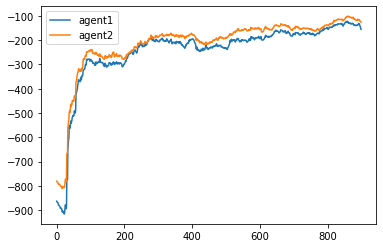

In [48]:
plt.plot([np.mean(agent_minimax.R_sum1[i:i+100]) for i in range(900)], label = "agent1")
plt.plot([np.mean(agent_minimax.R_sum2[i:i+100]) for i in range(900)], label = "agent2")
plt.legend()

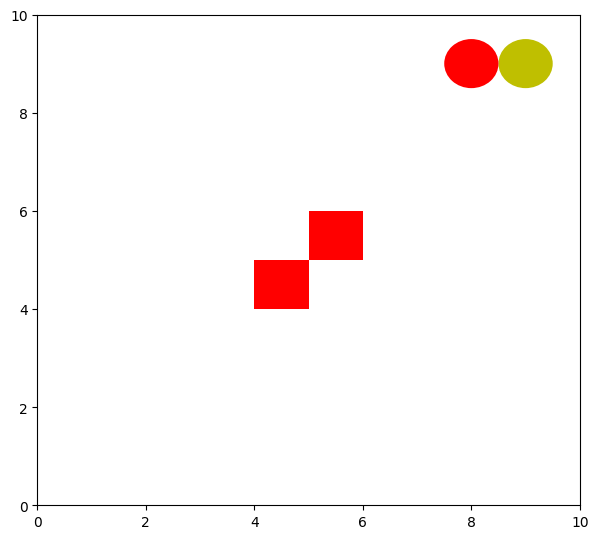

In [49]:
path1, path2 = agent_minimax.test(60, 30)
VisualizeMulti([path1, path2], [[5.5,5.5],[4.5,4.5]], [[5,5,'y'],[5,5,'r']]).show(np.max([len(path1),len(path2)]))

In [50]:
class multiAgentBB():
    def __init__(self, alpha, epsilon, goal = [9, 9], obstacle = [[5, 5]], dt = 1, discrite_action_count = 4, rad = [1], discrite_state_count = 10, discrite_state_limit = 10):
        action_count = discrite_action_count
        self.env = environment()
        self.alpha = alpha
        state_count = discrite_state_count**2
        self.Vs_A = np.zeros(state_count)
        self.Vs_B = np.zeros(state_count)
        self.policy_A = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa_A = np.zeros((action_count, action_count,state_count))
        self.policy_B = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa_B = np.zeros((action_count, action_count,state_count))
        self.action_count = action_count
        self.state_count = state_count
        self.R_avg1 = []
        self.R_sum1 = []
        self.R_avg2 = []
        self.R_sum2 = []
        if epsilon == 0:
            self.change_epsilon = True
        else:
            self.change_epsilon = False
            self.epsilon = epsilon
        if alpha == 0:
            self.change_alpha = True
        else:
            self.change_alpha = False
            self.alpha = alpha
        self.goal = goal
        if True:
            action = []
            t = np.array(range(discrite_action_count+1))/discrite_action_count*2*pi
            t = t[:-1]
            for  r in rad:
                for theta in t:
                    y = round(r*sin(theta),2)
                    x = round(r*cos(theta),2)
                    action.append([x, y])
            self.action = action
        if True:
            self.states = []
            self.statesp = {}
            xlist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            ylist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            for x in xlist:
                for y in ylist:
                    self.states.append([x,y])
                    self.statesp[str(x)+","+str(y)] = len(self.states)-1
        
    def select_action(self, Q_sa, state, action2 = 0):
        p = random.random()
        if p< 1-self.epsilon:
            action = np.argmax([Q_sa[i][action2][state] for i in range(self.action_count)])
            #action = np.argmax(np.max([[Q_sa[i][j][state] for j in range(self.action_count)] for i in range(self.action_count)]))
        else:
            action = np.random.choice([i for i in range(self.action_count)]) 
        return action   
    def update(self, state, action1, action2, reward, gama, state_p, v, Q_sa, P):
        Q_sa[action1][action2][state] = (1-self.alpha)*Q_sa[action1][action2][state] + self.alpha*(reward+gama*v[state_p])
        p = np.ones(self.action_count)#*self.epsilon/(self.action_count)
        #best = np.argmax([Q_sa[i][action2][state] for i in range(self.action_count)])
        #p[best] += (1-self.epsilon)    
        p = P/ np.sum(P)
        v[state_p] = np.max([np.sum([Q_sa[i][j][state]*p[j] for j in range(self.action_count)]) for i in range(self.action_count)])
        #v[state_p] = np.min([np.sum([Q_sa[i][j][state]*p[j] for i in range(self.action_count)]) for j in range(self.action_count)])
        return v
    def main_loop(self, gama = 0.9):
        gama = gama
        for k in range(10000):
            if self.change_epsilon:
                self.epsilon = 100/(100+k)
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            state1 = np.random.choice([i for i in range(self.state_count)])
            state2 = np.random.choice([i for i in range(self.state_count)])
            R1 = []
            R2 = []
            #[np.argmax([self.Q_sa[i][j] for i in range(self.action_count)]) for j in range(self.state_count)]
            action1 = self.select_action( self.Q_sa_A, state1)
            self.policy_A[action1] += 1
            action2 = self.select_action( self.Q_sa_B, state2, action1)
            self.policy_B[action2] += 1
            flag = False
            length = 0
            while True:
                length = length + 1
                if length > 2000:
                    break
                state_p1, reward1, done1 = self.env.step(self.map_state(state1), self.map_action(action1), self.goal, [self.map_state(state2)])
                state_p1 = self.statesp[str(float(round(state_p1[0])))+","+str(float(round(state_p1[1])))]
                R1.append(reward1)
                state_p2, reward2, done2 = self.env.step(self.map_state(state2), self.map_action(action2), self.goal, [self.map_state(state_p1)])
                state_p2 = self.statesp[str(float(round(state_p2[0])))+","+str(float(round(state_p2[1])))]
                R2.append(reward2)
                self.Vs_A = self.update(state1, action1, action2, reward1, gama, state_p1, self.Vs_A, self.Q_sa_A, self.policy_B)
                self.Vs_B = self.update(state2, action2, action1, reward2, gama, state_p2, self.Vs_B, self.Q_sa_B, self.policy_A)
                action_p1 = self.select_action( self.Q_sa_A, state_p1, action2)
                action_p2 = self.select_action( self.Q_sa_B, state_p2, action_p1)
                state1 = state_p1
                action1 = action_p1
                self.policy_A[action1] += 1
                state2 = state_p2
                action2 = action_p2
                self.policy_B[action2] += 1
                if done1 or done2:
                    if flag:
                        break
                    else:
                        flag = True
            self.R_avg1.append(np.mean(R1))
            self.R_sum1.append(np.sum(R1))
            self.R_avg2.append(np.mean(R2))
            self.R_sum2.append(np.sum(R2))
    def map_action(self, index):
        return  self.action[index]
    def map_state(self, index):
        return self.states[index]
    def test(self, state1, state2, gama = 0.9):
        gama = gama
        states1 = []
        states2 = []
        for k in range(1):
            R1 = []
            R2 = []
            #[np.argmax([self.Q_sa[i][j] for i in range(self.action_count)]) for j in range(self.state_count)]
            action1 = self.select_action( self.Q_sa_A, state1)
            action2 = self.select_action( self.Q_sa_B, state2, action1)
            flag = False
            length = 0
            while True:
                length = length + 1
                if length > 2000:
                    break
                state_p1, reward1, done1 = self.env.step(self.map_state(state1), self.map_action(action1), self.goal)
                states1.append(state_p1)
                state_p1 = self.statesp[str(float(round(state_p1[0])))+","+str(float(round(state_p1[1])))]
                R1.append(reward1)
                state_p2, reward2, done2 = self.env.step(self.map_state(state2), self.map_action(action2), self.goal)
                states2.append(state_p2)
                state_p2 = self.statesp[str(float(round(state_p2[0])))+","+str(float(round(state_p2[1])))]
                R2.append(reward2)
                self.epsilon = 0
                action_p1 = self.select_action( self.Q_sa_A, state_p1, action2)
                action_p2 = self.select_action( self.Q_sa_B, state_p2, action_p1)
                state1 = state_p1
                action1 = action_p1
                state2 = state_p2
                action2 = action_p2
                if done1 or done2:
                    if flag:
                        break
                    else:
                        flag = True
            self.R_avg1.append(np.mean(R1))
            self.R_sum1.append(np.sum(R1))
            self.R_avg2.append(np.mean(R2))
            self.R_sum2.append(np.sum(R2))
        return states1, states2

In [55]:
agent_BB =  multiAgentBB(0.1,0.1, obstacle = [[5.5,5.5],[4.5,4.5]])
agent_BB.main_loop()

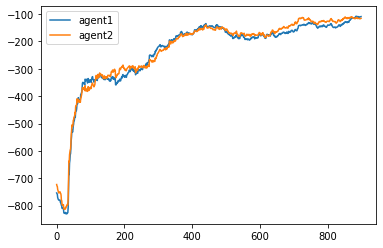

In [56]:
plt.plot([np.mean(agent_BB.R_sum1[i:i+100]) for i in range(900)], label = "agent1")
plt.plot([np.mean(agent_BB.R_sum2[i:i+100]) for i in range(900)], label = "agent2")
plt.legend()

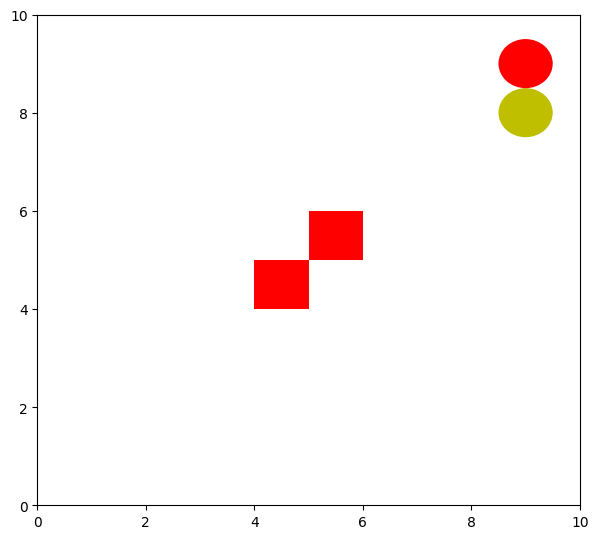

In [57]:
path1, path2 = agent_BB.test(60, 30)
VisualizeMulti([path1, path2], [[5.5,5.5],[4.5,4.5]], [[5,5,'y'],[5,5,'r']]).show(np.max([len(path1),len(path2)]))

In [58]:
class multiAgentFF():
    def __init__(self, alpha, epsilon, goal = [9, 9], obstacle = [[5, 5]], dt = 1, discrite_action_count = 4, rad = [1], discrite_state_count = 10, discrite_state_limit = 10):
        action_count = discrite_action_count
        self.env = environment()
        self.alpha = alpha
        state_count = discrite_state_count**2
        self.Vs_A = np.zeros(state_count)
        self.Vs_B = np.zeros(state_count)
        self.policy_A = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa_A = np.zeros((action_count, action_count,state_count))
        self.policy_B = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa_B = np.zeros((action_count, action_count,state_count))
        self.action_count = action_count
        self.state_count = state_count
        self.R_avg1 = []
        self.R_sum1 = []
        self.R_avg2 = []
        self.R_sum2 = []
        if epsilon == 0:
            self.change_epsilon = True
        else:
            self.change_epsilon = False
            self.epsilon = epsilon
        if alpha == 0:
            self.change_alpha = True
        else:
            self.change_alpha = False
            self.alpha = alpha
        self.goal = goal
        if True:
            action = []
            t = np.array(range(discrite_action_count+1))/discrite_action_count*2*pi
            t = t[:-1]
            for  r in rad:
                for theta in t:
                    y = round(r*sin(theta),2)
                    x = round(r*cos(theta),2)
                    action.append([x, y])
            self.action = action
        if True:
            self.states = []
            self.statesp = {}
            xlist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            ylist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            for x in xlist:
                for y in ylist:
                    self.states.append([x,y])
                    self.statesp[str(x)+","+str(y)] = len(self.states)-1
        
    def select_action(self, Q_sa, state, action2 = 0):
        p = random.random()
        if p< 1-self.epsilon:
            action = np.argmax([Q_sa[i][action2][state] for i in range(self.action_count)])
            #action = np.argmax(np.max([[Q_sa[i][j][state] for j in range(self.action_count)] for i in range(self.action_count)]))
        else:
            action = np.random.choice([i for i in range(self.action_count)]) 
        return action   
    def update(self, state, action1, action2, reward, gama, state_p, v, Q_sa, P):
        Q_sa[action1][action2][state] = (1-self.alpha)*Q_sa[action1][action2][state] + self.alpha*(reward+gama*v[state_p])
        p = np.ones(self.action_count)#*self.epsilon/(self.action_count)
        #best = np.argmax([Q_sa[i][action2][state] for i in range(self.action_count)])
        #p[best] += (1-self.epsilon)    
        p = P/ np.sum(P)
        v[state_p] = np.max(Q_sa[:,:,state])
        #v[state_p] = np.min([np.sum([Q_sa[i][j][state]*p[j] for i in range(self.action_count)]) for j in range(self.action_count)])
        return v
    def main_loop(self, gama = 0.9):
        gama = gama
        for k in range(10000):
            if self.change_epsilon:
                self.epsilon = 100/(100+k)
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            state1 = np.random.choice([i for i in range(self.state_count)])
            state2 = np.random.choice([i for i in range(self.state_count)])
            R1 = []
            R2 = []
            #[np.argmax([self.Q_sa[i][j] for i in range(self.action_count)]) for j in range(self.state_count)]
            action1 = self.select_action( self.Q_sa_A, state1)
            self.policy_A[action1] += 1
            action2 = self.select_action( self.Q_sa_B, state2, action1)
            self.policy_B[action2] += 1
            flag = False
            length = 0
            while True:
                length = length + 1
                if length > 2000:
                    break
                state_p1, reward1, done1 = self.env.step(self.map_state(state1), self.map_action(action1), self.goal, [self.map_state(state2)])
                state_p1 = self.statesp[str(float(round(state_p1[0])))+","+str(float(round(state_p1[1])))]
                R1.append(reward1)
                state_p2, reward2, done2 = self.env.step(self.map_state(state2), self.map_action(action2), self.goal, [self.map_state(state_p1)])
                state_p2 = self.statesp[str(float(round(state_p2[0])))+","+str(float(round(state_p2[1])))]
                R2.append(reward2)
                self.Vs_A = self.update(state1, action1, action2, reward1, gama, state_p1, self.Vs_A, self.Q_sa_A, self.policy_B)
                self.Vs_B = self.update(state2, action2, action1, reward2, gama, state_p2, self.Vs_B, self.Q_sa_B, self.policy_A)
                action_p1 = self.select_action( self.Q_sa_A, state_p1, action2)
                action_p2 = self.select_action( self.Q_sa_B, state_p2, action_p1)
                state1 = state_p1
                action1 = action_p1
                self.policy_A[action1] += 1
                state2 = state_p2
                action2 = action_p2
                self.policy_B[action2] += 1
                if done1 or done2:
                    if flag:
                        break
                    else:
                        flag = True
            self.R_avg1.append(np.mean(R1))
            self.R_sum1.append(np.sum(R1))
            self.R_avg2.append(np.mean(R2))
            self.R_sum2.append(np.sum(R2))
    def map_action(self, index):
        return  self.action[index]
    def map_state(self, index):
        return self.states[index]
    def test(self, state1, state2, gama = 0.9):
        gama = gama
        states1 = []
        states2 = []
        for k in range(1):
            R1 = []
            R2 = []
            #[np.argmax([self.Q_sa[i][j] for i in range(self.action_count)]) for j in range(self.state_count)]
            action1 = self.select_action( self.Q_sa_A, state1)
            action2 = self.select_action( self.Q_sa_B, state2, action1)
            flag = False
            length = 0
            while True:
                length = length + 1
                if length > 2000:
                    break
                state_p1, reward1, done1 = self.env.step(self.map_state(state1), self.map_action(action1), self.goal)
                states1.append(state_p1)
                state_p1 = self.statesp[str(float(round(state_p1[0])))+","+str(float(round(state_p1[1])))]
                R1.append(reward1)
                state_p2, reward2, done2 = self.env.step(self.map_state(state2), self.map_action(action2), self.goal)
                states2.append(state_p2)
                state_p2 = self.statesp[str(float(round(state_p2[0])))+","+str(float(round(state_p2[1])))]
                R2.append(reward2)
                self.epsilon = 0
                action_p1 = self.select_action( self.Q_sa_A, state_p1, action2)
                action_p2 = self.select_action( self.Q_sa_B, state_p2, action_p1)
                state1 = state_p1
                action1 = action_p1
                state2 = state_p2
                action2 = action_p2
                if done1 or done2:
                    if flag:
                        break
                    else:
                        flag = True
            self.R_avg1.append(np.mean(R1))
            self.R_sum1.append(np.sum(R1))
            self.R_avg2.append(np.mean(R2))
            self.R_sum2.append(np.sum(R2))
        return states1, states2

In [59]:
agent_FF =  multiAgentFF(0.1,0.1, obstacle = [[5.5,5.5],[4.5,4.5]])
agent_FF.main_loop()

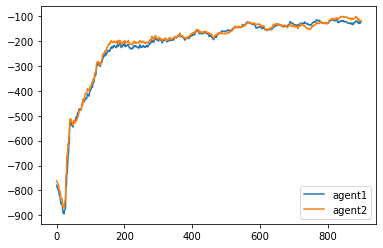

In [60]:
plt.plot([np.mean(agent_FF.R_sum1[i:i+100]) for i in range(900)], label = "agent1")
plt.plot([np.mean(agent_FF.R_sum2[i:i+100]) for i in range(900)], label = "agent2")
plt.legend()

Actor critic

In [ ]:
class ACMulti:
    def __init__(self, beta, alpha, gama, N, agentcount, goal = [9, 9], obstacle = [[5, 5]], discrite_action_count = 4, rad = [1], discrite_state_count = 10, discrite_state_limit = 10):
        action_count = discrite_action_count
        self.env = environment()
        self.alpha = alpha
        self.agentcount = agentcount
        state_count = discrite_state_count**2
        self.action_count = action_count
        self.state_count = state_count
        self.R_avg = []
        self.R_sum = []
        if alpha == 0:
            self.change_alpha = True
        else:
            self.change_alpha = False
            self.alpha = alpha
        if beta == 0:
            self.change_beta = True
        else:
            self.change_beta = False
            self.beta = beta
        self.goal = goal
        if True:
            action = []
            t = np.array(range(discrite_action_count+1))/discrite_action_count*2*pi
            t = t[:-1]
            for  r in rad:
                for theta in t:
                    y = round(r*sin(theta),2)
                    x = round(r*cos(theta),2)
                    action.append([x, y])
            self.action = action
        self.state = 0
        if True:
            self.states = []
            self.statesp = {}
            xlist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            ylist = np.array(range(discrite_state_count))/discrite_state_count * discrite_state_limit
            for x in xlist:
                for y in ylist:
                    self.states.append([x,y])
                    self.statesp[str(x)+","+str(y)] = len(self.states)-1
        self.N = N
        self.C = np.array([np.linspace(0, 1, N)*10,np.linspace(0, 1, N)*10,np.linspace(0, 1, N)*2-1,np.linspace(0, 1, N)*2-1]).T
        self.B = np.array([[0.1,0,0,0],[0,0.1,0,0],[0,0,0.1,0],[0,0,0,0.1]])
        self.C2 = [np.linspace(0, 1, N)*10,np.linspace(0, 1, N)*10]
        for i in range(self.agentcount):
            self.C2.append(np.linspace(0, 1, N)*2-1)
            self.C2.append(np.linspace(0, 1, N)*2-1)
        self.C2 = np.array(self.C2).T
        self.B2 = np.eye(self.agentcount*2+2)*0.1
        self.theta = np.ones((self.agentcount,N))
        self.w = np.ones((self.agentcount,N))
        self.mu = np.zeros(self.agentcount)
    def phi(self, state, action):
        Phi_vec=[]
        x = []
        for z in self.map_state(state):
            x.append(z)
        for z in self.map_action(action):
            x.append(z)
        for i in range(self.N):
            Phi_i=exp(-1/2*np.dot(np.dot(np.array(x-self.C[i]),np.linalg.pinv(self.B)),np.array(x-self.C[i])))
            Phi_vec.append(np.array(Phi_i))
        Phi_vec = np.array(Phi_vec)+0.001
        phi=Phi_vec/np.sum(Phi_vec)
        return np.array(phi)
    def phi2(self, state, actions):
        Phi_vec=[]
        x = []
        for z in self.map_state(state):
            x.append(z)
        for action in actions:
            for z in self.map_action(action):
                x.append(z)
        for i in range(self.N):
            Phi_i=exp(-1/2*np.dot(np.dot(np.array(x-self.C2[i]),np.linalg.pinv(self.B2)),np.array(x-self.C2[i])))
            Phi_vec.append(np.array(Phi_i))
        Phi_vec = np.array(Phi_vec)+0.001
        phi=Phi_vec/np.sum(Phi_vec)
        return np.array(phi)
    def select_action(self, state, index):
        p = np.array([np.exp(np.dot(self.phi(state, i),self.theta[index])) for i in range(self.action_count)])+0.001
        p = np.array(p)/np.sum(p)
        action = np.random.choice([i for i in range(self.action_count)], p = p)
        return action
    def Q(self, state, action, index, actions):   
        return np.dot(self.phi2(state, actions),self.theta[index])
    def Policy(self, state, action, index):
        p = np.array([np.exp(np.dot(self.phi(state, i),self.theta[index])) for i in range(self.action_count)])+0.001
        p = np.array(p)/np.sum(p)
        return p
    def update_Q(self, state, action, state_p, action_p, reward, gama, index, actions):
        delta = reward - self.mu[index] + gama*self.Q(state_p,action_p, index, actions) - self.Q(state,action, index, actions)
        self.w = self.w + self.beta*delta*self.Q(state,action, index, actions)
        p = self.Policy( state, action, index)
        A = self.Q(state,action, index, actions) - np.sum([p[i]*self.Q(state,i, index, actions) for i in range(self.action_count)])
        psy = np.dot(self.phi(state, action),self.theta[index])
        self.theta[index] = self.theta[index] + self.beta*A*psy
        return
    def main_loop(self, gama = 0.9):
        gama = gama
        for k in range(1000):
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            if self.change_beta:
                self.beta = 100/(1000+k)
            states = []
            for i in range(self.agentcount):
                states.append(np.random.choice([i for i in range(self.state_count)]))
            R = np.zeros(self.agentcount)
            Rt = []
            actions = []
            for i in range(self.agentcount):
                actions.append(self.select_action(states[i], i))
            flag = False
            length = 0
            state_ps = np.copy(states)
            action_ps = np.copy(actions)
            while True:
                length = length + 1
                if length > 200:
                    break
                for i in range(self.agentcount):
                    state_p, reward, done = self.env.step(self.map_state(states[i]), self.map_action(actions[i]), self.goal)
                    state_p = self.statesp[str(float(round(state_p[0])))+","+str(float(round(state_p[1])))]
                    state_ps[i] = state_p
                    R[i] = reward
                    self.mu[i] = (1-self.beta)*self.mu[i]+self.beta*reward
                    action_ps[i] = self.select_action(state_p, i)
                    if done:
                        flag = True
                Rt.append(R)
                for i in range(self.agentcount):
                    self.update_Q(states[i], actions[i], state_ps[i], action_ps[i], R[i], gama, i, actions)
                state_ps = np.copy(states)
                action_ps = np.copy(actions)
                if flag:
                        break
            self.R_avg.append(np.mean(Rt, axis = 0))
            self.R_sum.append(np.sum(Rt, axis = 0))
    def map_action(self, index):
        return  self.action[index]
    def map_state(self, index):
        return self.states[index]

In [ ]:
t = {}
agent =  ACMulti(beta = 0.1, alpha = 0.1, gama = 0.9, N = 1, agentcount = 2, obstacle = [[5.5,5.5],[4.5,4.5]])
agent.main_loop()
t["N=1"] = agent.R_sum
agent =  ACMulti(beta = 0.1, alpha = 0.1, gama = 0.9, N = 3, agentcount = 2, obstacle = [[5.5,5.5],[4.5,4.5]])
agent.main_loop()
t["N=3"] = agent.R_sum
agent =  ACMulti(beta = 0.1, alpha = 0.1, gama = 0.9, N = 10, agentcount = 2, obstacle = [[5.5,5.5],[4.5,4.5]])
agent.main_loop()
t["N=10"] = agent.R_sum

[]

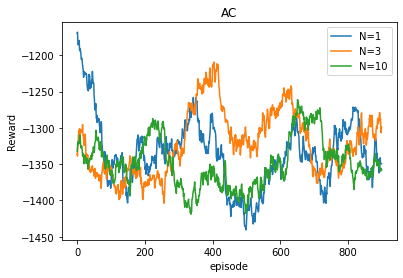

In [ ]:
plt.title("AC")
for k in t.keys():
    plt.plot([np.mean(t[k][i:i+100]) for i in range(900)], label = k)
plt.xlabel("episode")
plt.ylabel("Reward")
plt.legend()
plt.plot()